In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [130]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
PREFIX = "main/ycsb"

client_sdf = spark.read.csv(f"{PREFIX}/*/client/0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

server_sdf = spark.read.csv(f"{PREFIX}/*/server/0-0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

index_sdf = server_sdf.join(client_sdf, on='prefix')\
    .withColumn("duration", col("duration").cast(T.IntegerType()))\
    .withColumn("txns", col("txns").cast(T.IntegerType()))\
    .withColumn("clients", col("clients").cast(T.IntegerType()))\
    .withColumn("rate", col("rate").cast(T.IntegerType()))

index_df = index_sdf.toPandas()\
    .convert_dtypes()\
    .astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    })

# Throughput

## Compute everything or read from cache

In [178]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=40
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


cache_path = f'{PREFIX}/throughput.parquet'
if not IGNORE_CACHE and os.path.isfile(cache_path):
    throughput_df = pd.read_parquet(cache_path)
else:
    throughput_df = compute_all_throughputs(index_sdf)
    throughput_df.to_parquet(cache_path)
    print(f"Saved to: {cache_path}")

## Compute incrementally (only run if needed)

### Update rows

In [115]:
tdf = throughput_df
MASK = (tdf['config_name'] == 'ddr_only.conf') & (tdf['wl:hot'] == 10000) & (tdf['wl:mh'] == 100) & (tdf["wl:mp"] == 50)
throughput_df.loc[MASK, "throughput"] = throughput_df.loc[MASK, :].apply(lambda r : compute_throughput(r["prefix"]), axis=1)
throughput_df.to_parquet(cache_path)
print(f"Saved to: {cache_path}")

file:/home/ctring/data/slog/main/ycsb/ddr_only-hot10000mp50mh100 37641.852147931364
Saved to: main/ycsb/throughput.parquet


### Add new rows

In [127]:
new_rows = compute_all_throughputs(
    index_sdf.where(col("config_name") == "ddr_only_no_ddr.conf")
)

throughput_df = pd.concat([throughput_df, new_rows])

file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp0mh0 126913.74370409675
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp100mh0 48989.9348274513
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp50mh0 77912.7728713007
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp0mh0 112105.85403670403
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp100mh0 55390.55823149894
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp50mh0 73646.73628771887


In [ ]:
throughput_df.to_parquet(cache_path)
print(f"Saved to: {cache_path}")

## Plot

<AxesSubplot:xlabel='wl:hot,wl:mp,wl:mh'>

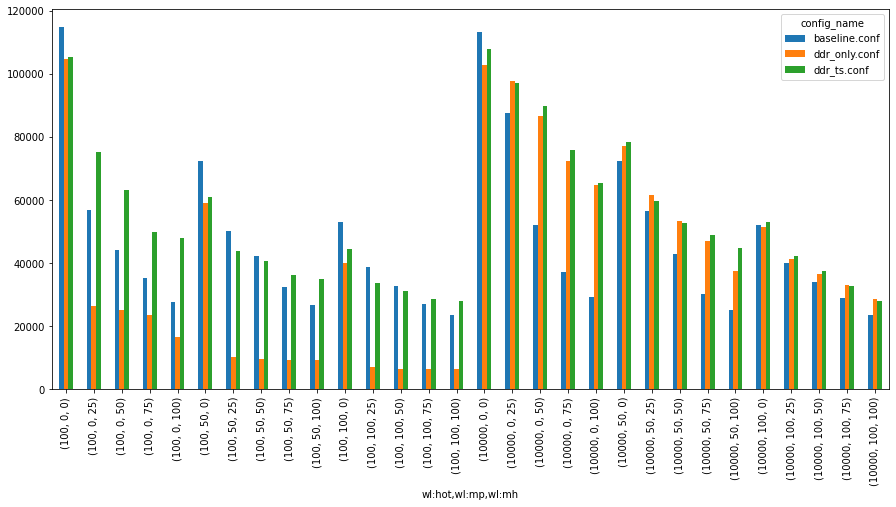

In [133]:
remove_constant_columns(throughput_df, ["config_name", "throughput"])
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = ["wl:hot", "wl:mp", "wl:mh"]

pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)
pivoted.sort_index().plot.bar(figsize=(15, 7))

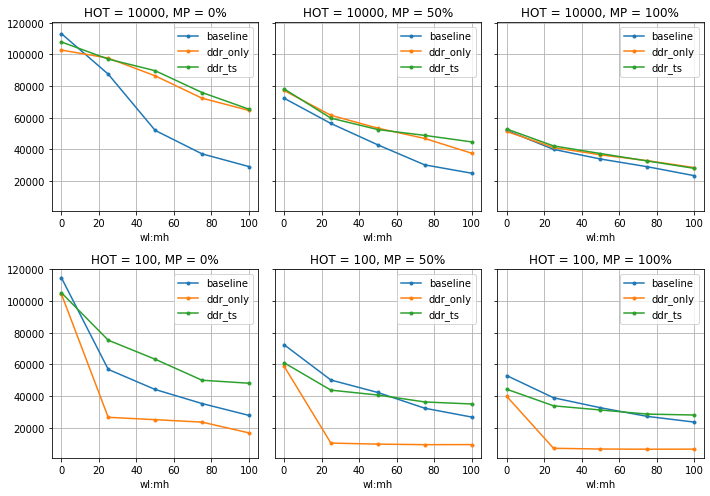

In [134]:
_, axes = plt.subplots(2, 3, figsize=(10, 7), sharey=True)

configs = throughput_df["config_name"].unique()
mp_pcts = sorted(throughput_df["wl:mp"].unique())
hots = sorted(throughput_df["wl:hot"].unique(), reverse=True)

for config in configs:
    for r, hot in enumerate(hots):
        for c, mp_pct in enumerate(mp_pcts):
            mask = (throughput_df["config_name"] == config) & (throughput_df["wl:mp"] == mp_pct) & (throughput_df["wl:hot"] == hot)
            label = config.replace('.conf', '')
            throughput_df[mask].sort_values("wl:mh").plot(ax=axes[r, c], x="wl:mh", y="throughput", label=label, marker='.')
            axes[r, c].set_title(f"HOT = {hot}, MP = {mp_pct}%")
            axes[r, c].grid()
    
plt.tight_layout()

# Deadlocks

In [187]:
prefix = "file:/home/ctring/data/slog/main/ycsb/ddr_ts-hot100mp0mh100"


# Latency

In [181]:
prefixes = list(map(lambda r : r["prefix"], index_sdf.select("prefix").collect()))
latency_sdf = latency(spark, prefixes).cache()

latency_50_sh_sdf = latency_sdf\
    .where(F.size("replicas") == 1)\
    .groupBy("prefix")\
    .agg(F.percentile_approx("latency", 0.5).alias("percentile_50"))\
    .cache()

latency_50_mh_sdf = latency_sdf\
    .where(F.size("replicas") > 1)\
    .groupBy("prefix")\
    .agg(F.percentile_approx("latency", 0.5).alias("percentile_50"))\
    .cache()

In [182]:
latency_50_sh_df = latency_50_sh_sdf.toPandas().merge(index_df, on="prefix")
latency_50_mh_df = latency_50_mh_sdf.toPandas().merge(index_df, on="prefix")

<AxesSubplot:xlabel='wl:hot,wl:mp,wl:mh'>

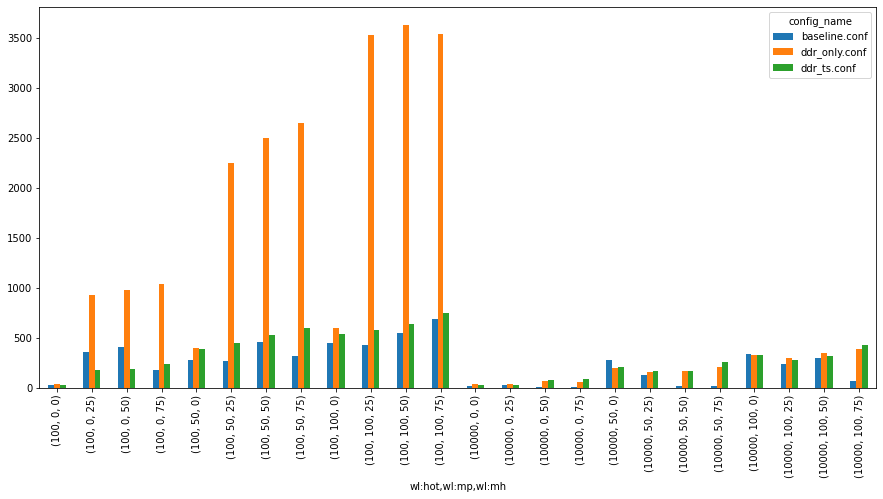

In [183]:
remove_constant_columns(latency_50_sh_df, ["config_name", "percentile_50"])
pivot_values = "percentile_50"
pivot_columns = "config_name"
pivot_index = ["wl:hot", "wl:mp", "wl:mh"]
pivoted = latency_50_sh_df[~latency_50_sh_df["config_name"].isin(["ddr_only_no_ddr.conf", "ddr_ts_no_ddr.conf"])]\
    .pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)
pivoted.sort_index().plot.bar(figsize=(15, 7))

<AxesSubplot:xlabel='wl:hot,wl:mp,wl:mh'>

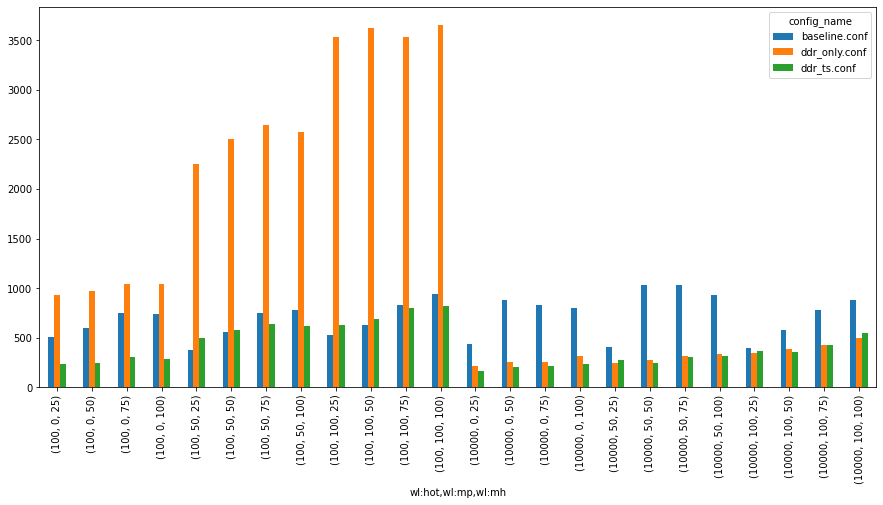

In [184]:
remove_constant_columns(latency_50_mh_df, ["config_name", "percentile_50"])
pivot_values = "percentile_50"
pivot_columns = "config_name"
pivot_index = ["wl:hot", "wl:mp", "wl:mh"]
pivoted = latency_50_mh_df[~latency_50_mh_df["config_name"].isin(["ddr_only_no_ddr.conf", "ddr_ts_no_ddr.conf"])]\
    .pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)
pivoted.sort_index().plot.bar(figsize=(15, 7))